In [1]:
import os
import cv2
# from cv_bridge import CvBridge
import bagpy
import rosbag
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
"""
    Ref: https://answers.ros.org/question/350904/cv_bridge-throws-boost-import-error-in-python-3-and-ros-melodic/
    Provides conversions between OpenCV and ROS image formats in a hard-coded way.  
    CV_Bridge, the module usually responsible for doing this, is not compatible with Python 3,
     - the language this all is written in.  So we create this module, and all is... well, all is not well,
     - but all works.  :-/
"""
import sys
import numpy as np
from sensor_msgs.msg import Image

def imgmsg_to_cv2(img_msg, msg_type):
#     print(img_msg.height, img_msg.width, len(img_msg.data), img_msg.encoding)
    if msg_type == 'color':
        dtype = np.dtype("uint8") # Hardcode to 8 bits...
        img_shape = (img_msg.height, img_msg.width, 3)
    elif msg_type == 'depth':
        dtype = np.dtype("uint16")
        img_shape = (img_msg.height, img_msg.width)
    else:
        raise Exception(f'Not supported msg_type {msg_type}')
                        
    dtype = dtype.newbyteorder('>' if img_msg.is_bigendian else '<')
    image_opencv = np.ndarray(shape=img_shape, dtype=dtype, buffer=img_msg.data)
    if img_msg.encoding == "rgb8":
        image_opencv = cv2.cvtColor(image_opencv, cv2.COLOR_RGB2BGR)
    # If the byt order is different between the message and the system.
    if img_msg.is_bigendian == (sys.byteorder == 'little'):
        image_opencv = image_opencv.byteswap().newbyteorder()
    return image_opencv

def cv2_to_imgmsg(cv_image):
    img_msg = Image()
    img_msg.height = cv_image.shape[0]
    img_msg.width = cv_image.shape[1]
    img_msg.encoding = "bgr8"
    img_msg.is_bigendian = 0
    img_msg.data = cv_image.tostring()
    img_msg.step = len(img_msg.data) // img_msg.height # That double line is actually integer division, not a comment
    return img_msg

In [7]:
BAGFILE = '/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/2023-01-03-19-05-34.bag'
DATADIR = '/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data'

In [8]:
b = bagreader(BAGFILE)

# get the list of topics
print(b.topic_table)

[INFO]  Data folder /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/2023-01-03-19-05-34 already exists. Not creating.
                                    Topics              Types  Message Count  \
0                                    /odom  nav_msgs/Odometry            808   
1  camera/aligned_depth_to_color/image_raw  sensor_msgs/Image           1357   
2                   camera/color/image_raw  sensor_msgs/Image           1730   

   Frequency  
0  15.820219  
1  29.633243  
2  30.155758  


In [9]:
# color = b.message_by_topic('/camera/color/image_raw')
depth = b.message_by_topic('/camera/aligned_depth_to_color/image_raw')
pose = b.message_by_topic('/odom')

No data on the topic:/camera/aligned_depth_to_color/image_raw


In [10]:
import csv

timestamps = []

with open("/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/2023-01-03-19-05-34/odom.csv", 'r') as file:
  csvreader = csv.reader(file)
  for i,row in enumerate(csvreader):
    if i==0:
      continue
    timestamps.append(row[0])
    # timestamps.append(''.join(str(row[0]).split('.')))

timestamps = np.array([float(x) for x in timestamps])

In [20]:
# BAGFILE = '/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/2023-01-03-19-05-34.bag'
# DATADIR = '/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data'

os.makedirs(DATADIR, exist_ok=True)
bag = rosbag.Bag(BAGFILE)


for dirname in ['color', 'depth', 'colored_depth','pose']:
    os.makedirs(os.path.join(DATADIR, dirname), exist_ok=True)

# [('camera/color/image_raw', 'color'), ('camera/aligned_depth_to_color/image_raw', 'depth')]

names = []

for TOPIC, dirname in [('camera/color/image_raw', 'color'), ('camera/aligned_depth_to_color/image_raw', 'depth')]:
    image_topic = bag.read_messages(TOPIC)
    for k, b in enumerate(image_topic):
        # bridge = CvBridge()
        cv_image = imgmsg_to_cv2(b.message, dirname)     
        
        curr_timestamp = float(str(b.timestamp))
        curr_timestamp = curr_timestamp / (10**(len(str(b.timestamp))-10))
        idx = (np.abs(timestamps - curr_timestamp)).argmin()

        filename_timestamp = ''.join(str(timestamps[idx]).split('.'))
        # names.append(filename_timestamp)
        # print(curr_timestamp,filename_timestamp)
        # continue

        if (dirname == 'depth'):
            np.save(os.path.join(DATADIR, dirname, filename_timestamp + '.npy'), cv_image)
            cv_image = cv2.applyColorMap(cv2.convertScaleAbs(cv_image, alpha=0.03), cv2.COLORMAP_JET)
            result = cv2.imwrite(os.path.join(DATADIR, 'colored_depth', filename_timestamp + '.png'), cv_image)
        else:
            result = cv2.imwrite(os.path.join(DATADIR, dirname, filename_timestamp + '.png'), cv_image)
#         print(str(result) + f' saved: {dirname} ' + str(b.timestamp))


bag.close()

## To extract pose data

In [12]:
df = pd.read_csv('/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/2023-01-03-19-05-34/odom.csv')
# print(df[100])
df.head()

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,child_frame_id,pose.pose.position.x,pose.pose.position.y,pose.pose.position.z,pose.pose.orientation.x,...,pose.pose.orientation.z,pose.pose.orientation.w,pose.covariance,twist.twist.linear.x,twist.twist.linear.y,twist.twist.linear.z,twist.twist.angular.x,twist.twist.angular.y,twist.twist.angular.z,twist.covariance
0,1.672753e+09,1387,1672752934,501799356,odom,base_link,-0.000031,0.0,0.0,0.0,...,0.000028,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.672753e+09,1388,1672752934,543835660,odom,base_link,-0.000031,0.0,0.0,0.0,...,0.000028,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.672753e+09,1389,1672752934,604812650,odom,base_link,-0.000031,0.0,0.0,0.0,...,0.000028,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.672753e+09,1390,1672752934,646757292,odom,base_link,-0.000031,0.0,0.0,0.0,...,0.000028,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.672753e+09,1391,1672752934,707833167,odom,base_link,-0.000031,0.0,0.0,0.0,...,0.000028,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


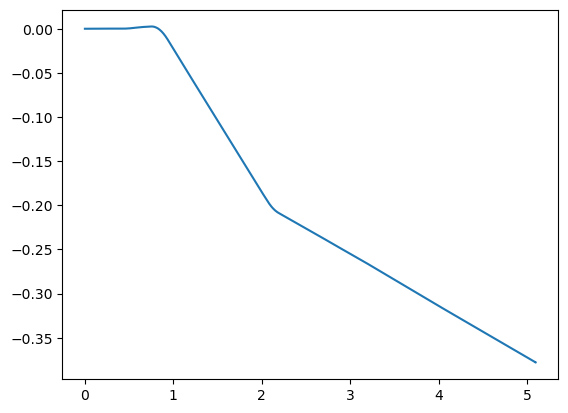

In [13]:
posx = df['pose.pose.position.x']
posy = df['pose.pose.position.y']
plt.plot(posx,posy)

In [14]:
from scipy.spatial.transform import Rotation as R

In [16]:
for ind in df.index:
    filename = ''.join(str(df['Time'][ind]).split('.'))
    while(len(filename)<20):
        filename += '0'
    filename += ".txt"


    theta_x = df['pose.pose.orientation.x'][ind]
    theta_y = df['pose.pose.orientation.y'][ind]
    theta_z = df['pose.pose.orientation.z'][ind]
    
    r = R.from_rotvec(np.array([theta_x,theta_y,theta_z])).as_matrix()
    
    disp = np.zeros((3,1))
    disp[2][0] = df['pose.pose.position.x'][ind]
    disp[1][0] = df['pose.pose.position.y'][ind]
    disp[0][0] = df['pose.pose.position.z'][ind]

    r = np.hstack((r,disp))
    r = np.vstack((r,np.array([0,0,0,1])))
    
    np.savetxt('/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/pose/'+filename,r)

### Renaming files 


In [22]:
import os

root_dir = '/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/color'
files = os.listdir('/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/color')

for file in files:
    new_file = file
    new_file = new_file.split('.')
    while(len(new_file[0])<20):
        new_file[0] += "0"
    os.rename(root_dir+"/"+file , root_dir+"/"+new_file[0] + '.' + new_file[1])

# for file in files:
#     new_file = file
#     while(new_file[-1]!='g'):
#         new_file = new_file[:-1]
#     os.rename(root_dir+"/"+file , root_dir+"/"+new_file)

### PCD registration

In [2]:
from pcdGenerate import generatePointCloud, getCameraIntrinsicMatrix
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
IMG_PATH = "/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/color"
DEPTH_PATH = "/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/depth"
POSE_PATH = "/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/pose"
# CAM_PATH = "/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/intrinsics/intrinsic_depth.txt"
SEG_PATH = "/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/segmentation"
TOP_DOWN_PATH = "/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/topdownmaps"

In [4]:
camera_intrinsics = np.array([[641.4490966796875 ,0.0 ,646.7113037109375 ,0.0],
                            [0.0, 639.9080200195312 ,362.441162109375 ,0.0],
                            [0.0 ,0.0 ,1.0, 0.0],
                            [0.0, 0.0, 0.0 ,1.0]])
# np.savetxt(CAM_PATH,camera_intrinsics)

In [5]:
fx = camera_intrinsics[0][0]
fy = camera_intrinsics[1][1]
S = camera_intrinsics[0][1]
cx = camera_intrinsics[0][2]
cy = camera_intrinsics[1][2]

camera_intrinsics = o3d.camera.PinholeCameraIntrinsic(width=640, height=480, fx=fx,fy=fy,cx=cx,cy=cy)

In [ ]:
# camera_intrinsics = getCameraIntrinsicMatrix(camera_intrinsics)

pcd_raw, reg_pcd, transforms = generatePointCloud(IMG_PATH, DEPTH_PATH, POSE_PATH, camera_intrinsics)

In [6]:
o3d.visualization.draw_geometries([reg_pcd])
# print(np.asarray(pcd_raw.points).shape)

In [6]:
def getSegmentationMask(seg):
    mask = np.ones(seg.shape)
    
    floor_area = seg[500:,:]
    floor_label = np.argmax(np.bincount(floor_area.flatten()))
    # plt.figure()
    # plt.imshow(floor_area)
    # print("hi")
    # print(floor_label)

    mask = seg == floor_label
    return mask

In [7]:
posepath = POSE_PATH
depthpath = DEPTH_PATH
imgpath = IMG_PATH
segpath = SEG_PATH

MAP_W = 100
MAP_H = 100
PAD = 0
S = 0.05

scans_list = os.listdir(posepath)
# print(scans_list)
scans_list = [scan.split('.')[0] for scan in scans_list]

pcd_list = np.empty((0,3))
color_list = np.empty((0,3))

# for i,scan in enumerate(scans_list):
for i,scan in enumerate(scans_list):

    depth_file = depthpath+"/"+scan+'.npy'
    image_file = imgpath+'/'+scan+'.png'
    seg_file = segpath+'/'+scan+'.png'


    if(not os.path.exists(depth_file) or not os.path.exists(image_file)):
        continue
    
    try:
        depth_map = o3d.geometry.Image(np.ascontiguousarray(np.load(depth_file)).astype(np.float32))
        rgb_img = cv2.cvtColor(cv2.imread(image_file),cv2.COLOR_BGR2RGB)
        seg_img = cv2.imread(seg_file)
    except:
        print(f"error caused due to {depth_file} or {image_file}")
        continue
    
    # here
    mask = getSegmentationMask(seg_img[:,:,0])
    mask = ~mask
    depth_map = np.array(depth_map)
    depth_map = depth_map*mask    
    depth_map =  depth_map.astype(np.float32) 
    
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(rgb_img), o3d.geometry.Image(depth_map),convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsics)

    # o3d.visualization.draw_geometries([pcd])

    map = np.zeros((MAP_H,MAP_W))
    points = np.array(pcd.points)
    points2D = np.array([points[:,0],points[:,2]]).T

    for point in points2D:
        px = point[0]
        py = point[1]
        # if(py>2 or abs(px)>1):
        #     continue

        indx = int(px/S) + PAD + MAP_W//2
        indy = int(py/S) + PAD + MAP_H//2

        map[indy,indx] = 1
    plt.figure()     
    plt.imshow(map)
    plt.show()

    break
    # Transform the point cloud in local frame to global world coordinates
    # pose = np.loadtxt(posepath+'/'+scan+'.txt',dtype=np.float32)
    # pcd.transform(pose)
    # Downsampling the pointcloud
    # pcd = pcd.uniform_down_sample(100)
    # pcd= pcd.voxel_down_sample(voxel_size=0.01)
    
    # print(np.asarray(pcd.points).shape, rgb_img.shape)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_list)
pcd.colors = o3d.utility.Vector3dVector(color_list)

 

error caused due to /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/depth/16727529579616196000.npy or /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/color/16727529579616196000.png
error caused due to /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/depth/16727529345031114000.npy or /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/color/16727529345031114000.png
error caused due to /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/depth/16727529345440216000.npy or /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/color/16727529345440216000.png
error caused due to /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/depth/16727529346049898000.npy or /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/color/16727529346049898000.png
error caused due to /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/depth/16727529347080140000.npy or /media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/color/

: 

In [75]:
o3d.visualization.draw_geometries([pcd])

### Results


In [124]:
o3d.visualization.draw_geometries([pcd_raw])

In [19]:
o3d.io.write_point_cloud('/media/god-particle/DA48D0B148D08D9F/shaantanu_honours/data/pcd/point_cloud.pcd',pcd_raw)

True

In [15]:
pcd_raw = o3d.io.read_point_cloud("../run_1.pcd")

In [16]:
print(np.asarray(pcd_raw.points))

[[ 9.33306217 -2.30053425 -0.35928547]
 [ 9.40629292 -2.3038981  -0.36893374]
 [ 9.23414326 -2.2579062  -0.36955494]
 ...
 [10.52008057  3.27205753  1.50502264]
 [10.55663109  3.2790823   1.5035876 ]
 [10.52713776  3.31420565  1.50103056]]


TOP DOWN MAP GENERATION

In [18]:
points = np.array(pcd_raw.points)
colors = np.array(pcd_raw.colors)
# points[:,2] *= -1
idx = np.where((points[:,2] >0.15) & (points[:,2] < 1.2) )[0] 
# idx = np.where((points[:,2] >0.1) )[0] 

# print(idx)
# print(points[[idx]])
points = points[idx]
colors = colors[idx]

print(np.min(points[:,2]))

# MAP_MAX = int(np.max(points[:,0])) + 1
# MAP_MAX1 = int(np.max(points[:,1])) + 1


# # print(points.shape) 
# # points[:,1] = 0
# pcd_test = o3d.geometry.PointCloud()
# pcd_test.points = o3d.utility.Vector3dVector(points)
# pcd_test.colors = o3d.utility.Vector3dVector(colors)
# o3d.visualization.draw_geometries([pcd_test])

0.15004225075244904


In [19]:
MAP_W = 500
MAP_H = 500
PAD = 0
S = 0.05

In [20]:
map = np.zeros((MAP_H,MAP_W))
points2D = np.array([points[:,0],points[:,1]]).T

for point in points2D:
    px = point[0]
    py = point[1]

    indx = int(px/S) + PAD + MAP_W//2
    indy = int(py/S) + PAD + MAP_H//2

    map[indy,indx] = 1

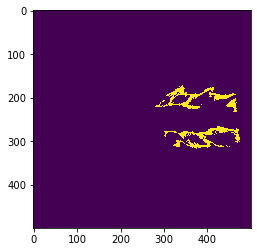

In [21]:
plt.imshow(map)